
# wMAE Evaluation (√ weighting)

This notebook computes the **weighted Mean Absolute Error (wMAE)** between a **truth** CSV and a **prediction** CSV,
comparing all shared numeric properties **except** `wavelength_range`.

We use the square‑root rebalancing you specified:
\[
w_i=\left(\frac{1}{r_i}\right)\left(\frac{K\sqrt{1/n_i}}{\sum_{j=1}^{K}\sqrt{1/n_j}}\right),
\qquad
\text{wMAE}=\frac{1}{|M|}\sum_{i=1}^{K}w_i\sum_{m\in\text{valid}_i}\lvert y_i(m)-\hat y_i(m)\rvert.
\]


## 1) Configure file paths

In [46]:

# Update these if your files live elsewhere
truth_path = "100testbank.csv"
pred_path_prev  = "100prediction_3epoch.csv"
pred_path_curr = "100prediction_6epoch.csv"

# Exclude properties from scoring
exclude = {"wavelength_range"}



In [1]:
truth_path = "3000testbank.csv"
exclude = {"wavelength_range"}

# prediction CSVs
pred_path_ai    = "properties_extracted_6epoch.csv"
pred_path_llama = "properties_extracted_llama.csv"
pred_path_qwen  = "properties_extracted_filtered_qwen.csv"
pred_path_gpt4o = "properties_extracted_gpt.csv"


## 2) Imports and wMAE function (√ weighting)

In [2]:

import math
from typing import List, Optional, Set

import numpy as np
import pandas as pd
from IPython.display import display

def _find_join_key(truth_cols: List[str], pred_cols: List[str], id_cols: Optional[List[str]] = None) -> Optional[str]:
    cand = id_cols if id_cols else ["SMILES", "smiles", "ID", "id", "Name", "name"]
    for c in cand:
        if c in truth_cols and c in pred_cols:
            return c
    return None

def compute_wmae(truth_path: str,
                 pred_path: str,
                 id_cols: Optional[List[str]] = None,
                 exclude: Optional[Set[str]] = None,
                 return_details: bool = False):
    exclude = set(exclude or set())
    truth = pd.read_csv(truth_path)
    pred  = pd.read_csv(pred_path)

    # Align rows by ID if possible, else by position (with length check)
    join_key = _find_join_key(list(truth.columns), list(pred.columns), id_cols)
    if join_key:
        merged = pd.merge(truth, pred, on=join_key, how="inner", suffixes=("", "__pred"))
        M = len(merged)
    else:
        if len(truth) != len(pred):
            raise ValueError("No shared identifier found and row counts differ; provide an ID column to join.")
        merged = pd.concat([truth.reset_index(drop=True),
                            pred.reset_index(drop=True).add_suffix("__pred")], axis=1)
        M = len(merged)

    # Choose comparable numeric properties
    props = []
    for col in truth.columns:
        if col == join_key:
            continue
        if col in exclude:
            continue
        pred_col = f"{col}__pred"
        if pred_col not in merged.columns:
            continue
        t_vals = pd.to_numeric(merged[col], errors="coerce")
        p_vals = pd.to_numeric(merged[pred_col], errors="coerce")
        if t_vals.notna().any() and p_vals.notna().any():
            props.append(col)

    if not props:
        raise ValueError("No comparable numeric properties found after exclusions.")

    K = len(props)

    sqrt_inv_ns = []
    rows = []
    for col in props:
        t = pd.to_numeric(merged[col], errors="coerce")
        p = pd.to_numeric(merged[f"{col}__pred"], errors="coerce")
        mask = t.notna() & p.notna()
        ni = int(mask.sum())
        if ni == 0:
            rows.append(dict(property=col, ni=0, ri=np.nan, sqrt_inv_ni=0.0, weight=0.0, abs_err_sum=0.0))
            sqrt_inv_ns.append(0.0)
            continue
        t_valid = t[mask]
        p_valid = p[mask]
        abs_err_sum = (t_valid - p_valid).abs().sum()
        ri = float(t_valid.max() - t_valid.min())
        sqrt_inv_ni = math.sqrt(1.0 / ni)
        sqrt_inv_ns.append(sqrt_inv_ni)
        rows.append(dict(property=col, ni=ni, ri=ri, sqrt_inv_ni=sqrt_inv_ni, weight=np.nan, abs_err_sum=float(abs_err_sum)))

    denom = float(sum(sqrt_inv_ns)) if sum(sqrt_inv_ns) > 0 else 1.0
    for d in rows:
        ri = d["ri"]; ni = d["ni"]
        if ni == 0 or (ri is None) or (not isinstance(ri, (int, float))) or (ri == 0) or (isinstance(ri, float) and math.isnan(ri)):
            d["weight"] = 0.0
        else:
            d["weight"] = (1.0 / ri) * (K * d["sqrt_inv_ni"] / denom)

    if M == 0:
        raise ValueError("|M| is zero after alignment.")
    wmae_num = sum(d["weight"] * d["abs_err_sum"] for d in rows)
    wmae = wmae_num / M

    details_df = pd.DataFrame(rows, columns=["property", "ni", "ri", "sqrt_inv_ni", "weight", "abs_err_sum"]).sort_values("property")
    if return_details:
        return wmae, M, K, wmae_num, details_df
    return wmae


## 3) Compute wMAE

In [48]:

wmae_ai, M_prev, K_ai, wmae_num_ai, details_ai = compute_wmae(
    truth_path, pred_path_prev, exclude=exclude, return_details=True
)
wmae_curr, M_curr, K_curr, wmae_num_curr, details_curr = compute_wmae(
    truth_path, pred_path_curr, exclude=exclude, return_details=True
)



In [3]:
wmae_ai, M_ai, K_ai, wmae_num_ai, details_ai = compute_wmae(
    truth_path, pred_path_ai, exclude=exclude, return_details=True
)

# ---- llama-3.1-70B ----
wmae_llama, M_llama, K_llama, wmae_num_llama, details_llama = compute_wmae(
    truth_path, pred_path_llama, exclude=exclude, return_details=True
)

# ---- Qwen2.5-32B ----
wmae_qwen, M_qwen, K_qwen, wmae_num_qwen, details_qwen = compute_wmae(
    truth_path, pred_path_qwen, exclude=exclude, return_details=True
)

# ---- gpt-4o ----
wmae_gpt4o, M_gpt4o, K_gpt4o, wmae_num_gpt4o, details_gpt4o = compute_wmae(
    truth_path, pred_path_gpt4o, exclude=exclude, return_details=True
)

## 4) Save per‑property breakdown

In [ ]:

from pathlib import Path
out_csv = Path("wmae_details_sqrt.csv")
details_df.to_csv(out_csv, index=False)
print("Saved details to:", out_csv)


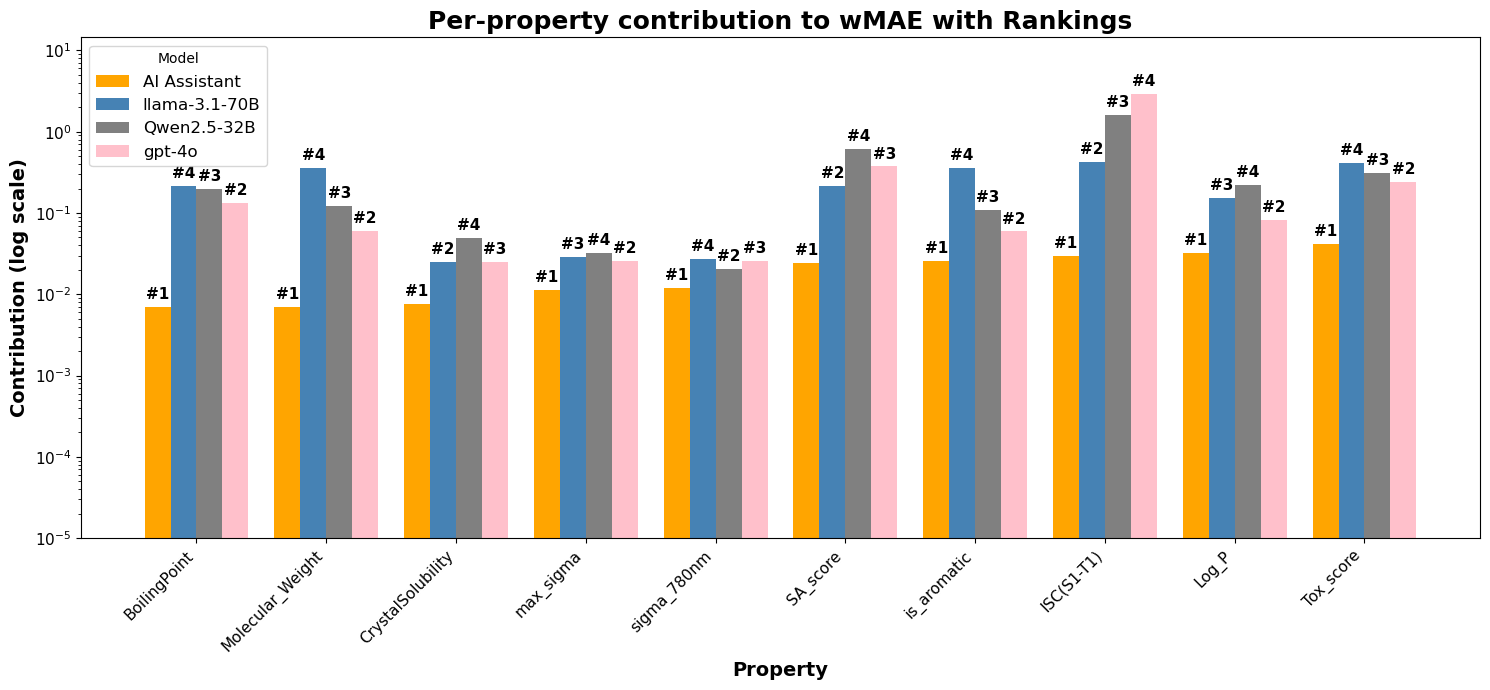

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute per-property contributions -------------------------------------
contrib_ai = details_ai.assign(
    contribution=lambda d: d["weight"] * d["abs_err_sum"] / M_ai
)[["property", "contribution"]]

contrib_llama = details_llama.assign(
    contribution=lambda d: d["weight"] * d["abs_err_sum"] / M_llama
)[["property", "contribution"]]

contrib_qwen = details_qwen.assign(
    contribution=lambda d: d["weight"] * d["abs_err_sum"] / M_qwen
)[["property", "contribution"]]

contrib_gpt4o = details_gpt4o.assign(
    contribution=lambda d: d["weight"] * d["abs_err_sum"] / M_gpt4o
)[["property", "contribution"]]

# ------------------------------------------------------------
# Merge contribution tables
# ------------------------------------------------------------

merged = (
    contrib_ai.rename(columns={"contribution": "AI_Assistant"})
    .merge(contrib_llama.rename(columns={"contribution": "LLaMA_70B"}), on="property")
    .merge(contrib_qwen.rename(columns={"contribution": "Qwen_32B"}), on="property")
    .merge(contrib_gpt4o.rename(columns={"contribution": "GPT4o"}), on="property")
)

# Sort by any model (optional)
merged = merged.sort_values("AI_Assistant", ascending=True)

models = ["AI_Assistant", "LLaMA_70B", "Qwen_32B", "GPT4o"]

# ------------------------------------------------------------
# Compute ranking per row (property)
# ------------------------------------------------------------
def rank_row(row):
    # lower is better → rank 1 is smallest
    values = row[models].values
    order = np.argsort(values)        # indices of sorted (lowest→highest)
    ranks = np.empty_like(order)
    ranks[order] = np.arange(1, len(values)+1)  # assign 1..4
    return ranks

rank_matrix = np.vstack([rank_row(row) for _, row in merged.iterrows()])

# ------------------------------------------------------------
# PLOT
# ------------------------------------------------------------

x = np.arange(len(merged))
width = 0.20

fig, ax = plt.subplots(figsize=(15, 7))

bars_ai = ax.bar(
    x - 1.5*width, merged["AI_Assistant"], width,
    label="AI Assistant", color="orange"
)
bars_llama = ax.bar(
    x - 0.5*width, merged["LLaMA_70B"], width,
    label="llama-3.1-70B", color="steelblue"
)
bars_qwen = ax.bar(
    x + 0.5*width, merged["Qwen_32B"], width,
    label="Qwen2.5-32B", color="grey"
)
bars_gpt = ax.bar(
    x + 1.5*width, merged["GPT4o"], width,
    label="gpt-4o", color="pink"
)

# Log-scale
ax.set_yscale("log")
ax.set_ylim(1e-5, merged[models].values.max() * 5)

# Bar collections in same order as 'models'
bars_all = [bars_ai, bars_llama, bars_qwen, bars_gpt]

# ------------------------------------------------------------
# Annotate rankings & (optionally) numeric values
# ------------------------------------------------------------
for i, bars in enumerate(bars_all):      # loop models
    for j, bar in enumerate(bars):       # loop properties
        height = bar.get_height()
        rank = rank_matrix[j, i]

        # Ranking text — placed above the bar
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height * 1.15,
            f"#{rank}",
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold",
        )



# ------------------------------------------------------------
# Labels & formatting
# ------------------------------------------------------------
ax.set_xticks(x)
ax.set_xticklabels(
    merged["property"],
    rotation=45,
    ha="right",
    fontsize=12        # ← larger font for property labels
)

ax.set_ylabel(
    "Contribution (log scale)",
    fontsize=14,       # ← larger y-axis label
    fontweight="bold"
)

ax.set_xlabel(
    "Property",
    fontsize=14,       # ← larger x-axis label
    fontweight="bold"
)

ax.tick_params(axis="y", labelsize=11)   # ← larger y tick labels
ax.tick_params(axis="x", labelsize=11)   # ← larger x tick labels

ax.set_title(
    "Per-property contribution to wMAE with Rankings",
    fontsize=18,       # ← larger title
    fontweight="bold"
)

#ax.grid(axis="y", linestyle="--", alpha=0.5, which="both")
ax.legend(title="Model", fontsize=12, title_fontsize=10)

fig.tight_layout()

plt.savefig("wmae_contribution_4models_rank_log.png", dpi=300, bbox_inches="tight")
plt.savefig("wmae_contribution_4models_rank_log.pdf", dpi=600, bbox_inches="tight")
plt.show()


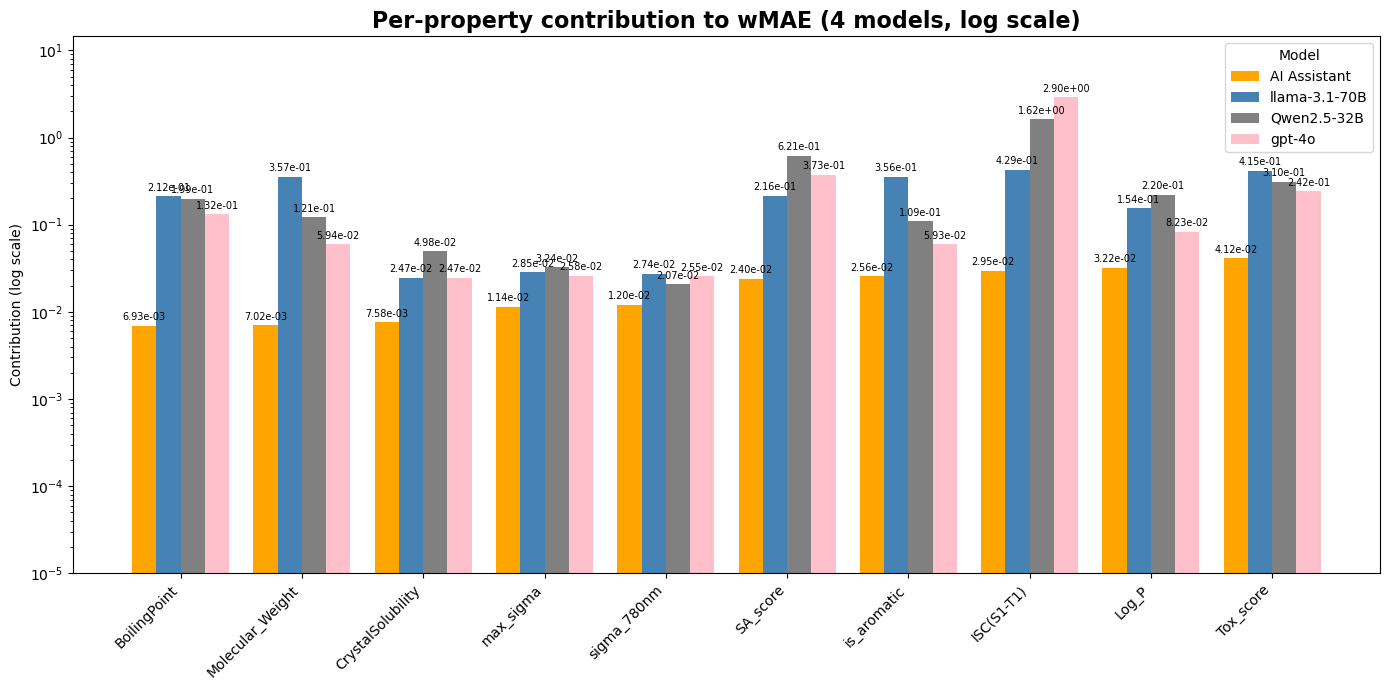

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Compute per-property contributions -------------------------------------
contrib_ai = details_ai.assign(
    contribution=lambda d: d["weight"] * d["abs_err_sum"] / M_ai
)[["property", "contribution"]]

contrib_llama = details_llama.assign(
    contribution=lambda d: d["weight"] * d["abs_err_sum"] / M_llama
)[["property", "contribution"]]

contrib_qwen = details_qwen.assign(
    contribution=lambda d: d["weight"] * d["abs_err_sum"] / M_qwen
)[["property", "contribution"]]

contrib_gpt4o = details_gpt4o.assign(
    contribution=lambda d: d["weight"] * d["abs_err_sum"] / M_gpt4o
)[["property", "contribution"]]
# ------------------------------------------------------------
# Merge 4 models' contributions into one table
# All DataFrames must contain columns: ["property", "contribution"]
# ------------------------------------------------------------

merged = (
    contrib_ai[["property", "contribution"]].rename(columns={"contribution": "AI_Assistant"})
    .merge(
        contrib_llama[["property", "contribution"]].rename(columns={"contribution": "LLaMA_70B"}),
        on="property",
    )
    .merge(
        contrib_qwen[["property", "contribution"]].rename(columns={"contribution": "Qwen_32B"}),
        on="property",
    )
    .merge(
        contrib_gpt4o[["property", "contribution"]].rename(columns={"contribution": "GPT4o"}),
        on="property",
    )
)

# Sort properties by AI model's contribution (any column is fine)
merged = merged.sort_values("AI_Assistant", ascending=True)

# ------------------------------------------------------------
# PLOT
# ------------------------------------------------------------
x = np.arange(len(merged))
width = 0.20

fig, ax = plt.subplots(figsize=(14, 7))

bars_ai = ax.bar(
    x - 1.5*width, merged["AI_Assistant"], width,
    label="AI Assistant", color="orange"
)
bars_llama = ax.bar(
    x - 0.5*width, merged["LLaMA_70B"], width,
    label="llama-3.1-70B", color="steelblue"
)
bars_qwen = ax.bar(
    x + 0.5*width, merged["Qwen_32B"], width,
    label="Qwen2.5-32B", color="grey"
)
bars_gpt = ax.bar(
    x + 1.5*width, merged["GPT4o"], width,
    label="gpt-4o", color="pink"
)


# ------------------------------------------------------------
# LOG-SCALE Y AXIS
# ------------------------------------------------------------
ax.set_yscale("log")
ax.set_ylim(1e-5, merged[["AI_Assistant","LLaMA_70B","Qwen_32B","GPT4o"]].values.max() * 5)

# ------------------------------------------------------------
# Annotate bars (position adjusted for log scale)
# ------------------------------------------------------------
for bars in [bars_ai, bars_llama, bars_qwen, bars_gpt]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height * 1.1,               # Slightly above bar
            f"{height:.2e}",            # scientific notation recommended for log
            ha="center",
            va="bottom",
            fontsize=7,
        )

# ------------------------------------------------------------
# Labels & formatting
# ------------------------------------------------------------
ax.set_xticks(x)
ax.set_xticklabels(merged["property"], rotation=45, ha="right")
ax.set_title("Per-property contribution to wMAE (4 AI models)", fontsize=16, weight="bold")
ax.set_ylabel("Contribution (log scale)")
#ax.grid(axis="y", linestyle="--", alpha=0.5, which="both")
ax.legend(title="Model", fontsize=10)

fig.tight_layout()

plt.savefig("wmae_contribution_4models_log.png", dpi=300, bbox_inches="tight")
plt.savefig("wmae_contribution_4models_log.pdf", dpi=600, bbox_inches="tight")
plt.show()

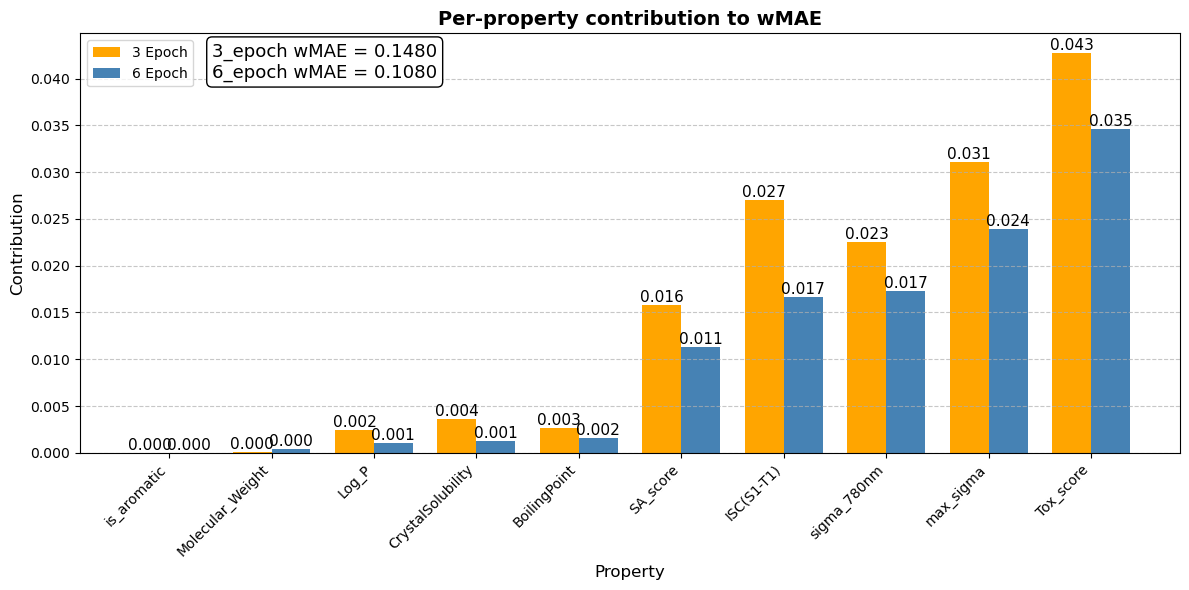

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute per-property contributions -------------------------------------
contrib_prev = details_prev.assign(
    contribution=lambda d: d["weight"] * d["abs_err_sum"] / M_prev
)
contrib_curr = details_curr.assign(
    contribution=lambda d: d["weight"] * d["abs_err_sum"] / M_curr
)

# Align properties and put into one DataFrame
merged = (
    contrib_prev[["property", "contribution"]]
    .rename(columns={"contribution": "contrib_prev"})
    .merge(
        contrib_curr[["property", "contribution"]]
        .rename(columns={"contribution": "contrib_curr"}),
        on="property",
        how="inner",
    )
)

# Sort by current contribution (or change to "contrib_prev" if you prefer)
merged = merged.sort_values("contrib_curr", ascending=True)

# --- Grouped bar plot -------------------------------------------------------
x = np.arange(len(merged))
width = 0.38

fig, ax = plt.subplots(figsize=(12, 6))

bars_prev = ax.bar(
    x - width / 2,
    merged["contrib_prev"],
    width,
    label="3 Epoch",
    color="orange",
)
bars_curr = ax.bar(
    x + width / 2,
    merged["contrib_curr"],
    width,
    label="6 Epoch",
    color="steelblue",
)

# Annotate each bar with its value
for bar in list(bars_prev) + list(bars_curr):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=11,
    )

ax.set_xticks(x)
ax.set_xticklabels(merged["property"], rotation=45, ha="right")
ax.set_title("Per-property contribution to wMAE", fontsize=14, weight="bold")
ax.set_xlabel("Property", fontsize=12)
ax.set_ylabel("Contribution", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Show both wMAE values in a box
ax.text(
    0.12,
    0.895,
    f"3_epoch wMAE = {wmae_prev:.4f}\n6_epoch wMAE = {wmae_curr:.4f}",
    transform=ax.transAxes,
    fontsize=13,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

ax.legend()
fig.tight_layout()

plt.savefig("wmae_contribution_compare.png", dpi=300, bbox_inches="tight")
plt.savefig("wmae_contribution_compare.pdf", dpi=600, bbox_inches="tight")
plt.show()

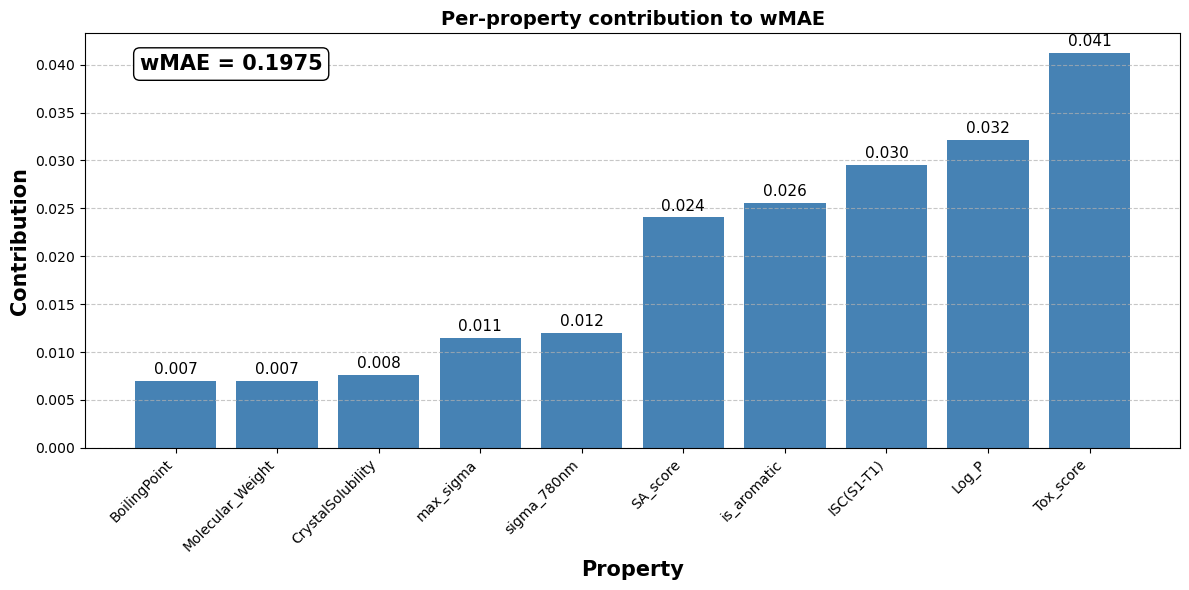

In [8]:
import matplotlib.pyplot as plt

# Compute contribution
contrib = details_ai.assign(
    contribution=lambda d: d["weight"] * d["abs_err_sum"] / M_ai
)

# Sort by contribution (ascending)
contrib_sorted = contrib.sort_values("contribution", ascending=True)

plt.figure(figsize=(12, 6))
bars = plt.bar(
    contrib_sorted["property"],
    contrib_sorted["contribution"],
    color="steelblue"
)

# Add labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * contrib_sorted["contribution"].max(),  # small offset
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=11
    )

# Add text box in upper-left corner
plt.gca().text(
    0.05, 0.95,                       # x, y (in axes fraction coords)
    f"wMAE = {wmae_ai:.4f}",                # text
    ha="left", va="top",              # anchor to top-left
    transform=plt.gca().transAxes,    # relative to axes (0–1)
    fontsize=15, weight="bold",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
)


plt.xticks(rotation=45, ha="right")
plt.title("Per-property contribution to wMAE", fontsize=14, weight="bold")
plt.xlabel("Property", fontsize=15, fontweight="bold")
plt.ylabel("Contribution", fontsize=15, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save outputs
plt.savefig("wmae_contribution.png", dpi=300, bbox_inches="tight")
plt.savefig("wmae_contribution.pdf", dpi=600, bbox_inches="tight")  # high-res PDF
plt.show()